In [18]:
import zipfile
import shapely.geometry as shpg
import salem
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import matplotlib.pyplot as plt

In [19]:
files = glob.glob('dhdt/*.tif')
err_files = glob.glob('dhdt_err/*.tif')

In [20]:
files[:10]

['dhdt/N63W066_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N36E078_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/S70E016_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N74W090_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N60W146_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N52W177_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N75E059_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N42E072_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N77E016_2000-01-01_2020-01-01_dhdt.tif',
 'dhdt/N31E100_2000-01-01_2020-01-01_dhdt.tif']

In [21]:
assert len(files) == len(err_files)

In [22]:
gdf = gpd.GeoDataFrame()

# First round for the main file
for i, f in enumerate(files):
        gdf.loc[i, 'file_id'] = f.split('dhdt/')[1].split('_')[0]
        gdf.loc[i, 'dhdt'] = f
        
gdf = gdf.sort_values(by=['file_id'])
gdf = gdf.reset_index(drop=True)

# Second round for all the others
for i, f in enumerate(err_files):
    err_id = f.split('dhdt_err/')[1].split('_')[0]
    sel = gdf.loc[gdf.file_id == err_id]
    assert len(sel) == 1
    gdf.loc[sel.index, 'dhdt_err'] = f

gdf

file_id                                         dhdt  \
0     N00E029  dhdt/N00E029_2000-01-01_2020-01-01_dhdt.tif   
1     N00W078  dhdt/N00W078_2000-01-01_2020-01-01_dhdt.tif   
2     N00W079  dhdt/N00W079_2000-01-01_2020-01-01_dhdt.tif   
3     N02W077  dhdt/N02W077_2000-01-01_2020-01-01_dhdt.tif   
4     N04W076  dhdt/N04W076_2000-01-01_2020-01-01_dhdt.tif   
...       ...                                          ...   
2100  S78W153  dhdt/S78W153_2000-01-01_2020-01-01_dhdt.tif   
2101  S78W154  dhdt/S78W154_2000-01-01_2020-01-01_dhdt.tif   
2102  S78W155  dhdt/S78W155_2000-01-01_2020-01-01_dhdt.tif   
2103  S79E166  dhdt/S79E166_2000-01-01_2020-01-01_dhdt.tif   
2104  S79E167  dhdt/S79E167_2000-01-01_2020-01-01_dhdt.tif   

                                               dhdt_err  
0     dhdt_err/N00E029_2000-01-01_2020-01-01_dhdt_er...  
1     dhdt_err/N00W078_2000-01-01_2020-01-01_dhdt_er...  
2     dhdt_err/N00W079_2000-01-01_2020-01-01_dhdt_er...  
3     dhdt_err/N02W077_2000-01-01_2020-01-01_dhdt_er...  
4     dhdt_err/N04W076_2000-01-01_2020-01-01_dhdt_er...  
...                                                 ...  
2100  dhdt_err/S78W153_2000-01-01_2020-01-01_dhdt_er...  
2101  dhdt_err/S78W154_2000-01-01_2020-01-01_dhdt_er...  
2102  dhdt_err/S78W155_2000-01-01_2020-01-01_dhdt_er...  
2103  dhdt_err/S79E166_2000-01-01_2020-01-01_dhdt_er...  
2104  dhdt_err/S79E167_2000-01-01_2020-01-01_dhdt_er...  

[2105 rows x 3 columns]

In [23]:
gdf.to_csv('hugonnet_dhdt_lookup_csv_20230129.csv')

In [7]:
for i, s in gdf.iterrows():
    if 'N71W180' not in s['dhdt']:
        continue
    dd = salem.GeoTiff(s['dhdt'])
    xx = dd.grid.extent_in_crs()
    gdf.loc[i, 'geometry'] = dd.grid.extent_as_polygon(salem.wgs84)
    break

In [17]:
np.array(dd.grid.extent_as_polygon(salem.wgs84).exterior.coords)

array([[179.94560517,  71.30120733],
       [179.94839594,  71.30125257],
       [179.95118672,  71.30129776],
       ...,
       [179.94588725,  71.2994167 ],
       [179.94574622,  71.30031202],
       [179.94560517,  71.30120733]])

In [9]:
if xx[0] < 0 and xx[1] > 0:
    

[-179.9995452463021, 179.9986321210502, 70.98246110040847, 71.31617283030506]

In [17]:
gdf = gpd.GeoDataFrame(gdf)

In [18]:
gdf.crs = salem.wgs84.crs.to_wkt()

In [20]:
import zipfile
import tarfile

def open_zip_shapefile(fpath, exclude_pattern='', include_pattern=''):
    with zipfile.ZipFile(fpath, "r") as z:
        for f in z.filelist:
            if f.filename.endswith('.shp'):
                if exclude_pattern and exclude_pattern in f.filename:
                    continue
                if include_pattern and include_pattern not in f.filename:
                    continue
                fname = f.filename
                
    return gpd.read_file('zip://' + fpath + '/' + fname)

# This could be made lazy to speed up imports
data_dir = '/home/www/fmaussion/misc/rgi7_data'

maps = {}
fpath = f'{data_dir}/l0_support_data/ne_10m_coastline.zip'
maps['coast_hr'] = open_zip_shapefile(fpath)
fpath = f'{data_dir}/l0_support_data/ne_50m_coastline.zip'
maps['coast_mr'] = open_zip_shapefile(fpath)
fpath = f'{data_dir}/l0_support_data/ne_110m_coastline.zip'
maps['coast_lr'] = open_zip_shapefile(fpath)
fpath = f'{data_dir}/l0_support_data/ne_10m_admin_0_countries.zip'
maps['countries_hr'] = open_zip_shapefile(fpath)
fpath = f'{data_dir}/l0_support_data/ne_50m_admin_0_countries.zip'
maps['countries_mr'] = open_zip_shapefile(fpath)
fpath = f'{data_dir}/l0_support_data/ne_110m_admin_0_countries.zip'
maps['countries_lr'] = open_zip_shapefile(fpath)

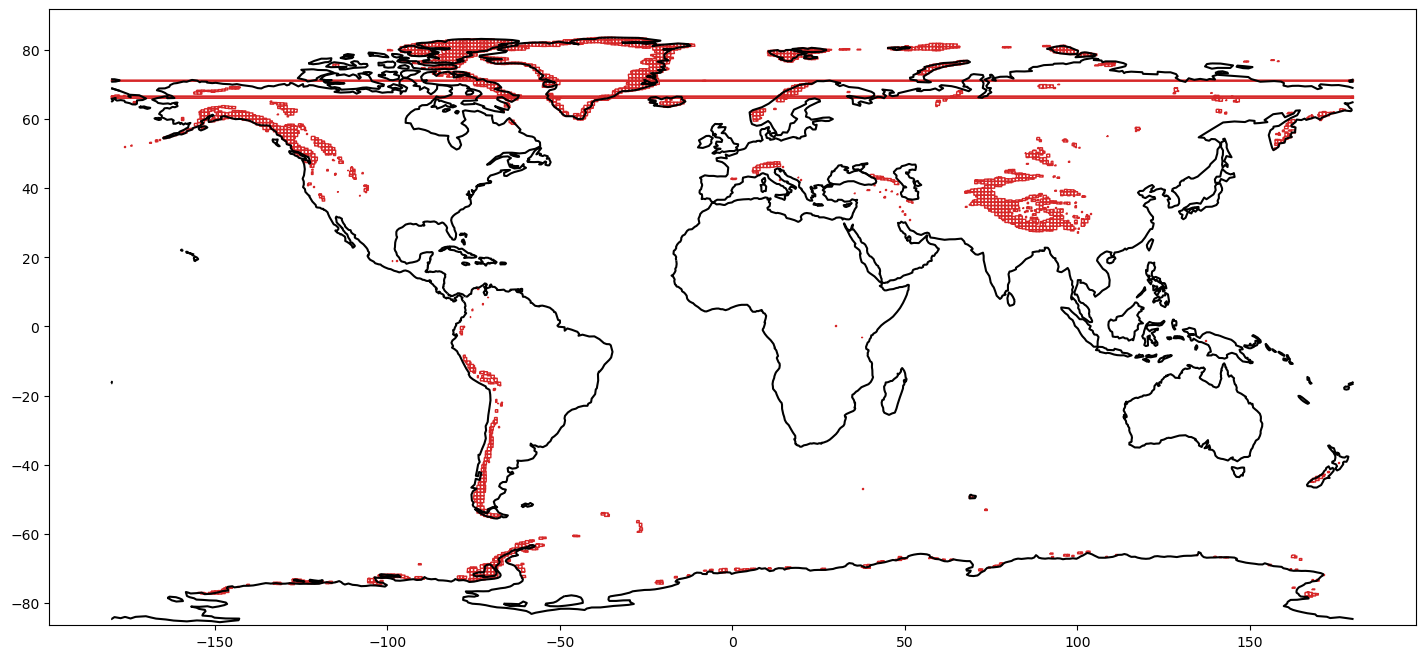

In [22]:
f, ax = plt.subplots(figsize=(18, 8))

gdf.plot(ax=ax, facecolor='none', edgecolor='C3', linewidth=1);
    
ax.autoscale(enable=False, axis='both', tight=True)
maps[f'coast_lr'].plot(ax=ax, facecolor='none', edgecolor='k', aspect=None);

# Alternative solution for "Polygon handles not passing to legend"
# ax.legend(handles=handles, loc=loc);
# if title is None:
#     title = f'RGI{reg:02d}'
# ax.set_title(title)

# if aspect is not None:
#     ax.set_aspect(aspect)

# if savefig:
#     plot_dir = data_dir + f'/l3_rgi7a_plots/RGI{reg:02d}'
#     mkdir(plot_dir)
#     plotname = 'isrgi6_map' if is_rgi6 else 'inventory_map'
#     plt.savefig(plot_dir + f'/{plotname}.png', bbox_inches='tight', dpi=150)

In [23]:
out_dir = 'hugonnet_dhdt_lookup_shp_20220926'
gdf.to_file(out_dir)
import shutil
shutil.make_archive(f'{out_dir}', 'zip', out_dir)
shutil.rmtree(out_dir)

In [18]:
import shapely.geometry as shpg
p = shpg.Point(-150, 60)
gdf.contains(p)

0      True
1     False
2     False
3     False
4     False
      ...  
56    False
57    False
58    False
59    False
60    False
Length: 61, dtype: bool

## Check grids:

In [33]:
for i, s in gdf.iterrows():
    g1 = salem.GeoTiff(s['thickness']).grid
    g2 = salem.GeoTiff(s['err']).grid
    
    if g1.nx != g2.nx or g1.ny != g2.ny:
        print(s.file_id + ' has a different grid size for thickness and error')
        continue
    
    if g1.x0 != g2.x0 or g1.y0 != g2.y0:
        print(s.file_id + ' has different coordinates for thickness and error')
        continue
    
    if g1.dx != g2.dx or g1.dy != g2.dy:
        print(s.file_id + ' has different grid resolution for thickness and error')
        continue

RGI-1.1_2021July01 has a different grid size for thickness and error
RGI-5.1_2022February24 has different coordinates for thickness and error
RGI-5.5_2022February24 has a different grid size for thickness and error
RGI-10.1_2021July09 has different coordinates for thickness and error
